# Impacts of 100% renewables in European countries - Annex

Some test cases for the study

We take as an example France (FR) in the year 2015

In [2]:
data = pd.read_csv('../data/FR_2015.csv').set_index(['Month', 'Day', 'Hour'])
data.describe()

,Consumption (MWh),Wind Charge Factor,Solar Charge Factor
count,"8,760.00","8,760.00","8,760.00"
mean,"54,006.72",0.24,0.13
std,"11,642.45",0.20,0.18
min,"29,589.52",0.00,0.00
25%,"45,230.34",0.09,0.00
50%,"52,568.66",0.17,0.02
75%,"61,807.79",0.34,0.26
max,"91,934.14",0.84,0.68


Now we have the data we need to decide our total capacity in wind and solar.
We start with a naive approach and say we need to have the average wind and solar production to match half of the average consumption

Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:47Md€
kWh Price: 0.176€


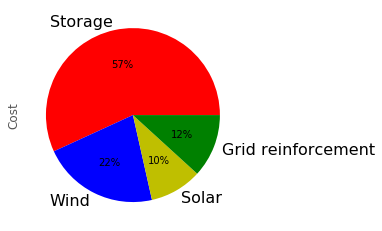

In [18]:
wind_lifetime = 25
solar_lifetime = 25
grid_lifetime = 50

# All expressed in M€ per MW per year
wind_capex = 1.5 / wind_lifetime
solar_capex = 1.5 / solar_lifetime
grid_capex = 1.5 / grid_lifetime
wind_opex = 0.02
solar_opex = 0.02


storage_capex = 0.1
storage_opex = 0.00001
storage_cycles = 1500

wind_yearly_cost = (wind_capex + wind_opex) * wind_capacity
solar_yearly_cost = (solar_capex + solar_opex) * solar_capacity
grid_yearly_cost = grid_capex * (wind_capacity + solar_capacity)
storage_yearly_cost = (storage_capex / storage_cycles * storage_cycles_peryear + storage_opex) * storage_capacity
print('Yearly costs Wind: %.0fMd€, Solar: %.0fMd€, Grid: %.0fMd€, Storage:%.0fMd€' 
      % (wind_yearly_cost/1000, solar_yearly_cost/1000, grid_yearly_cost/1000, storage_yearly_cost/1000))

total_yearly_cost = wind_yearly_cost + solar_yearly_cost + grid_yearly_cost + storage_yearly_cost
per_kwh_cost = total_yearly_cost / data.sum()['Consumption (MWh)'] * 1e6 / 1e3 
print('kWh Price: %.3f€' % (per_kwh_cost))

pd.DataFrame({'Concept':['Storage', 'Wind','Solar','Grid reinforcement'],
              'Cost': [storage_yearly_cost, wind_yearly_cost, solar_yearly_cost, grid_yearly_cost]})\
                    .set_index('Concept').plot.pie(y='Cost', legend=False, autopct='%1.0f%%')

# restore the storage capex for later
storage_capex = 0.2

But one should keep in mind that the wind, solar and storage capacities have been "guessed"

Let's now see if we can optimize them

## Let's optimize all that

To run an optimizer we first need to wrap all our code in a function

In [217]:
def calculate_cost(wind_capacity, solar_capacity, storage_capacity):

    data['Wind production (MWh)'] = data['Wind Charge Factor'] * wind_capacity 
    data['Solar production (MWh)'] = data['Solar Charge Factor'] * solar_capacity
    data['REN production (MWh)'] = data['Wind production (MWh)'] + data['Solar production (MWh)']
    data['Balance (MWh)'] = data['REN production (MWh)'] - data['Consumption (MWh)']
    

    currently_stored = storage_capacity / 2
    stored = []
    for index,row in data.iterrows():
        currently_stored = \
            max(min(currently_stored + row['Balance (MWh)'] * (storage_efficiency if row['Balance (MWh)'] > 0 else 1/storage_efficiency)
                    , storage_capacity), 0)
        stored += [currently_stored]
        if currently_stored == 0:
            # We don't want any black out so we penalize it with a prohibitive kWh cost
            print('Black out on ', index)
            return 99999999999;

    data['Stored (MWh)'] = stored
    
    wind_yearly_cost = (wind_capex + wind_opex) * wind_capacity
    solar_yearly_cost = (solar_capex + solar_opex) * solar_capacity
    grid_yearly_cost = grid_capex * (wind_capacity + solar_capacity)
    storage_yearly_cost = (storage_capex / storage_cycles * storage_cycles_peryear + storage_opex) * storage_capacity
    
    total_yearly_cost = wind_yearly_cost + solar_yearly_cost + grid_yearly_cost + storage_yearly_cost
    per_kwh_cost = total_yearly_cost / data.sum()['Consumption (MWh)'] * 1e6 / 1e3 
    
    return per_kwh_cost
    
# Check that we are getting expected results
cost = calculate_cost(wind_capacity, solar_capacity, storage_capacity)
print('kWh Price: %.3f€' % (cost))

kWh Price: 0.276€


In [ ]:
from scipy.optimize import minimize, fmin

def fopts(args):
    print('.', end='')
    return calculate_cost(args[0],args[1],args[2])

conso_mean = data.mean()['Consumption (MWh)']
wind_capacity = conso_mean/data.mean()['Wind Charge Factor']/2
solar_capacity = conso_mean/data.mean()['Solar Charge Factor']/2
storage_capacity = conso_mean * 24 * 15
storage_capex=0.01
solar_capex=0.1/solar_lifetime
solar_opex=0.005
init = [wind_capacity, solar_capacity, storage_capacity]
print('Initial Guess Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (init[0]/1000, init[1]/1000, init[2]/1e6))
print('Price per kWh :%.3f€' % calculate_cost(wind_capacity, solar_capacity, storage_capacity))
print('Start optimizing')
r = minimize(fopts, init,method='Nelder-Mead',tol=0.001, options={'xatol':1000})
print('')
print(r['message'])
sol=r['x']
print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (sol[0]/1000, sol[1]/1000, sol[2]/1e6))
print('Price per kWh :%.3f€' % r['fun'])

Initial Guess Capacity in Wind: 112.69GW, Solar: 201.91GW, Storage: 19.44TWh
Price per kWh :99999999999.000€
Start optimizing
.......

In [85]:
from scipy.optimize import basinhopping
print('Start optimizing')
r=basinhopping(fopts, init)
print(r)
sol=r['x']
print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (sol[0]/1000, sol[1]/1000, sol[2]/1e6))
print('Price per kWh :%.3f€' % r['fun'])

Start optimizing
.................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

In [396]:
print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (r[0]/1000, r[1]/1000, r[2]/1e6))
print('Price per kWh :%.2f€' % fopts(r))


Optimal Capacity in Wind: 465.46GW, Solar: 89.57GW, Storage: 3.91TWh
Yearly costs Wind: 37Md€, Solar: 7Md€, Grid: 17Md€, Storage:36Md€
Price per kWh :0.19€


In [397]:
# with battery at 100€/kWh
storage_capex=0.1
r = fmin(fopts, [wind_capacity, solar_capacity, storage_capacity], xtol=1000, ftol=0.01, disp=0)
print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (r[0]/1000, r[1]/1000, r[2]/1e6))
print('Price per kWh :%.2f€' % fopts(r))

Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:47Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:47Md€
Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:47Md€
Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:50Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:45Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:43Md€
Yearly costs Wind: 18Md€, Solar: 9Md€, Grid: 10Md€, Storage:44Md€
Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:42Md€
Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:45Md€
Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:44Md€
Yearly costs Wind: 18Md€, Solar: 9Md€, Grid: 10Md€, Storage:42Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:40Md€
Yearly costs Wind: 20Md€, Solar: 8Md€, Grid: 11Md€, Storage:38Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:42Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:40Md€
Yearly cos

Yearly costs Wind: 25Md€, Solar: 4Md€, Grid: 11Md€, Storage:34Md€
Price per kWh :0.15€


In [398]:
# with battery at 100€/kWh and 99% effeciency
storage_capex=0.1
storage_efficiency=0.99
r = fmin(fopts, [wind_capacity, solar_capacity, storage_capacity], xtol=1000, ftol=0.01, disp=0)
print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (r[0]/1000, r[1]/1000, r[2]/1e6))
print('Price per kWh :%.2f€' % fopts(r))

Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:47Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:47Md€
Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:47Md€
Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:50Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:45Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:43Md€
Yearly costs Wind: 18Md€, Solar: 9Md€, Grid: 10Md€, Storage:44Md€
Yearly costs Wind: 18Md€, Solar: 8Md€, Grid: 10Md€, Storage:42Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:39Md€
Yearly costs Wind: 19Md€, Solar: 9Md€, Grid: 10Md€, Storage:37Md€
Yearly costs Wind: 20Md€, Solar: 8Md€, Grid: 11Md€, Storage:35Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:40Md€
Yearly costs Wind: 19Md€, Solar: 8Md€, Grid: 10Md€, Storage:38Md€
Yearly costs Wind: 20Md€, Solar: 9Md€, Grid: 11Md€, Storage:34Md€
Yearly costs Wind: 19Md€, Solar: 9Md€, Grid: 10Md€, Storage:37Md€
Yearly cos

In [402]:
# add year 2014
data = pd.read_csv('../data/FR_2014.csv').set_index(['Month', 'Day', 'Hour'])
data = data.append(pd.read_csv('../data/FR_2015.csv').set_index(['Month', 'Day', 'Hour']))

storage_capex=0.2
storage_efficiency=0.90
r = fmin(fopts, [wind_capacity*2, solar_capacity*2, storage_capacity*2], xtol=1000, ftol=0.01, disp=0)
print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (r[0]/1000, r[1]/1000, r[2]/1e6))
print('Price per kWh :%.2f€' % fopts(r))

Yearly costs Wind: 36Md€, Solar: 16Md€, Grid: 20Md€, Storage:189Md€
Yearly costs Wind: 38Md€, Solar: 16Md€, Grid: 20Md€, Storage:189Md€
Yearly costs Wind: 36Md€, Solar: 17Md€, Grid: 20Md€, Storage:189Md€
Yearly costs Wind: 36Md€, Solar: 16Md€, Grid: 20Md€, Storage:198Md€
Yearly costs Wind: 37Md€, Solar: 17Md€, Grid: 20Md€, Storage:179Md€
Yearly costs Wind: 38Md€, Solar: 17Md€, Grid: 21Md€, Storage:170Md€
Yearly costs Wind: 35Md€, Solar: 17Md€, Grid: 20Md€, Storage:176Md€
Yearly costs Wind: 37Md€, Solar: 17Md€, Grid: 20Md€, Storage:168Md€
Yearly costs Wind: 37Md€, Solar: 16Md€, Grid: 20Md€, Storage:157Md€
Yearly costs Wind: 38Md€, Solar: 18Md€, Grid: 21Md€, Storage:147Md€
Yearly costs Wind: 38Md€, Solar: 18Md€, Grid: 21Md€, Storage:126Md€
Yearly costs Wind: 40Md€, Solar: 17Md€, Grid: 22Md€, Storage:126Md€
Yearly costs Wind: 39Md€, Solar: 18Md€, Grid: 21Md€, Storage:103Md€
Yearly costs Wind: 40Md€, Solar: 18Md€, Grid: 22Md€, Storage:69Md€
Yearly costs Wind: 42Md€, Solar: 19Md€, Grid: 23M

In [49]:
# We introduce a decrease of 0.5% in the wind farms load factor for each 10GW installed
current_wind_capacity = 10000
wind_factor_decrease = 0.0005
def calculate_cost(wind_capacity, solar_capacity, storage_capacity):

    data['Wind production (MWh)'] = data['Wind Charge Factor'] * (1-wind_factor_decrease * (wind_capacity/current_wind_capacity)**2) * wind_capacity 
    data['Solar production (MWh)'] = data['Solar Charge Factor'] * solar_capacity
    data['REN production (MWh)'] = data['Wind production (MWh)'] + data['Solar production (MWh)']
    data['Balance (MWh)'] = data['REN production (MWh)'] - data['Consumption (MWh)']
    
    currently_stored = storage_capacity / 2
    stored = []
    for index,row in data.iterrows():
        currently_stored = \
            max(min(currently_stored + row['Balance (MWh)'] * (storage_efficiency if row['Balance (MWh)'] > 0 else 1/storage_efficiency)
                    , storage_capacity), 0)
        stored += [currently_stored]
        if currently_stored == 0:
            # We don't want any black out so we penalize it with a prohibitive kWh cost
            return 99999999999;

    data['Stored (MWh)'] = stored
    
    wind_yearly_cost = (wind_capex + wind_opex) * wind_capacity
    solar_yearly_cost = (solar_capex + solar_opex) * solar_capacity
    grid_yearly_cost = grid_capex * (wind_capacity + solar_capacity)
    storage_yearly_cost = (storage_capex / storage_cycles * storage_cycles_peryear + storage_opex) * storage_capacity
    print('Yearly costs Wind: %.0fMd€, Solar: %.0fMd€, Grid: %.0fMd€, Storage:%.0fMd€' 
          % (wind_yearly_cost/1000, solar_yearly_cost/1000, grid_yearly_cost/1000, storage_yearly_cost/1000))

    total_yearly_cost = wind_yearly_cost + solar_yearly_cost + grid_yearly_cost + storage_yearly_cost
    per_kwh_cost = total_yearly_cost / data.sum()['Consumption (MWh)'] * 1e6 / 1e3 
    
    return per_kwh_cost

#calculate_cost(wind_capacity/10, solar_capacity, storage_capacity)
#print(data.describe())

r = fmin(fopts, [wind_capacity, solar_capacity*4, storage_capacity*4], xtol=1000, ftol=0.01, disp=0)
print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (r[0]/1000, r[1]/1000, r[2]/1e6))
print('Price per kWh :%.2f€' % fopts(r))

NameError: name 'fmin' is not defined

In [513]:
data = pd.read_csv('../data/ES_2015.csv').set_index(['Month', 'Day', 'Hour'])
print(data.describe())
wind_capacity = data.mean()['Consumption (MWh)']/data.mean()['Wind Charge Factor']
solar_capacity = data.mean()['Consumption (MWh)']/data.mean()['Solar Charge Factor']
solar_capacity = data.mean()['Consumption (MWh)']*24*6


r = fmin(fopts, [wind_capacity, solar_capacity, storage_capacity], xtol=1000, ftol=0.01, disp=0)
print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (r[0]/1000, r[1]/1000, r[2]/1e6))
print('Price per kWh :%.2f€' % fopts(r))

       Consumption (MWh)  Wind Charge Factor  Solar Charge Factor
count           8,759.00            8,759.00             8,759.00
mean           28,368.56                0.26                 0.18
std             4,648.78                0.22                 0.23
min            18,041.00                0.00                 0.00
25%            24,461.50                0.10                 0.00
50%            28,626.00                0.19                 0.02
75%            31,662.50                0.35                 0.35
max            40,324.00                1.00                 0.74
Yearly costs Wind: 9Md€, Solar: 327Md€, Grid: 126Md€, Storage:94Md€
Yearly costs Wind: 9Md€, Solar: 327Md€, Grid: 126Md€, Storage:94Md€
Yearly costs Wind: 9Md€, Solar: 343Md€, Grid: 132Md€, Storage:94Md€
Yearly costs Wind: 9Md€, Solar: 327Md€, Grid: 126Md€, Storage:99Md€
Yearly costs Wind: 9Md€, Solar: 310Md€, Grid: 120Md€, Storage:98Md€
Yearly costs Wind: 9Md€, Solar: 294Md€, Grid: 114Md€, Storage:99Md

In [514]:
data = pd.read_csv('../data/DE_2015.csv').set_index(['Month', 'Day', 'Hour'])
print(data.describe())
wind_capacity = data.mean()['Consumption (MWh)']/data.mean()['Wind Charge Factor']
solar_capacity = data.mean()['Consumption (MWh)']/data.mean()['Solar Charge Factor']
solar_capacity = data.mean()['Consumption (MWh)']*24*6


r = fmin(fopts, [wind_capacity, solar_capacity, storage_capacity], xtol=1000, ftol=0.01, disp=0)
print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (r[0]/1000, r[1]/1000, r[2]/1e6))
print('Price per kWh :%.2f€' % fopts(r))



       Consumption (MWh)  Wind Charge Factor  Solar Charge Factor
count           8,759.00            8,759.00             8,759.00
mean           57,680.88                0.22                 0.10
std            10,246.12                0.23                 0.16
min            35,062.00                0.00                 0.00
25%            48,920.50                0.05                 0.00
50%            57,259.00                0.13                 0.00
75%            66,850.00                0.33                 0.16
max            77,496.00                0.98                 0.66
Yearly costs Wind: 21Md€, Solar: 664Md€, Grid: 257Md€, Storage:94Md€
Yearly costs Wind: 22Md€, Solar: 664Md€, Grid: 257Md€, Storage:94Md€
Yearly costs Wind: 21Md€, Solar: 698Md€, Grid: 269Md€, Storage:94Md€
Yearly costs Wind: 21Md€, Solar: 664Md€, Grid: 257Md€, Storage:99Md€
Yearly costs Wind: 21Md€, Solar: 631Md€, Grid: 245Md€, Storage:98Md€
Yearly costs Wind: 22Md€, Solar: 598Md€, Grid: 232Md€, Storag

Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25Md€, Storage:111Md€
Yearly costs Wind: 23Md€, Solar: 44Md€, Grid: 25

In [306]:
wind_lifetime = 25
solar_lifetime = 25
grid_lifetime = 50

# All expressed in M€ per MW per year
wind_capex = 1.5 / wind_lifetime
solar_capex = 1.5 / solar_lifetime
grid_capex = 1.5 / grid_lifetime
wind_opex = 0.02
solar_opex = 0.02


storage_capex = 0.2
storage_opex = 0.00001
storage_cycles = 1500

In [321]:
from pulp import *
import datetime
prob=pulp.LpProblem("Minimum cost",pulp.LpMinimize)
nb_hours=len(data) #1000

# Optimized variables definition
wind_capa=LpVariable("Wind capacity GW",10,1000)
solar_capa=LpVariable("Solar capacity GW",10,1000)
storage_capa=LpVariable("Storage capacity GWh",0)

# We will pass stored as capacity at an hour t as a optimization parameter.
# In order to relax the constraint on production we also allow for a parameter losses 
# that represents at an instant t  the amount of production we haven't been able to store 
stored=[]
losses=[]
for i in range (0,nb_hours):
    stored.append(LpVariable("stored("+str(i)+")",0))
    losses.append(LpVariable("losses("+str(i)+")",0))

def total_yearly_cost():
    wind_yearly_cost = (wind_capex + wind_opex) * wind_capa * 1000
    solar_yearly_cost = (solar_capex + solar_opex) * solar_capa * 1000
    grid_yearly_cost = grid_capex * (wind_capa + solar_capa)* 1000
    storage_yearly_cost = (storage_capex / storage_cycles * storage_cycles_peryear + storage_opex) * storage_capa * 1000
    
    return wind_yearly_cost + solar_yearly_cost + grid_yearly_cost + storage_yearly_cost \
        + (storage_capa*nb_hours - lpSum(stored)) *1e-6

# Function to minimize
prob += total_yearly_cost(), "Cost"

wind_cf = data['Wind Charge Factor'].values
solar_cf = data['Solar Charge Factor'].values
consos = data['Consumption (MWh)'].values/1000


def system_equilibrium(i):
    if i> 0:
        return wind_cf[i] * wind_capa + solar_cf[i] * solar_capa - consos[i] + stored[i] - stored[i-1] - losses[i]
    else:
        return wind_cf[i] * wind_capa + solar_cf[i] * solar_capa - consos[i] + stored[0] - storage_capa / 2 - losses[0]

time_start = datetime.datetime.now()
    
# Constraints
for i in range(1,nb_hours):
    # system equilibrium at all time
    prob+= system_equilibrium(i) == 0 
    # storage won't go above capacity and not below 5%
    prob+= stored[i]<=storage_capa
    prob+= stored[i]>=0.10*storage_capa
    
print('time sprent creating constraints', datetime.datetime.now()-time_start)

time sprent creating constraints 0:00:01.814933


In [322]:
time_start = datetime.datetime.now()
prob.solve()
print('time sprent solving problem',datetime.datetime.now()-time_start)
print ("Status:", LpStatus[prob.status])

time sprent solving problem 0:00:05.865498
Status: Optimal


In [323]:
def find_var_index(var_string):
    return int(''.join([s for s in var_string if s.isdigit()]))
charges_best=[None]*nb_hours
discharges_best=[None]*nb_hours
stored_best=[None]*nb_hours
losses_best=[None]*nb_hours
for v in prob.variables():
    if v.name == 'Storage_capacity_GWh':
        storage_best=v.varValue
    elif v.name == 'Solar_capacity_GW':
        solar_best=v.varValue
    elif v.name == 'Wind_capacity_GW':
        wind_best=v.varValue
    elif v.name.startswith('stored'):
        ind = find_var_index(v.name)
        stored_best[ind]=v.varValue
    elif v.name.startswith('losses'):
        ind = find_var_index(v.name)
        losses_best[ind]=v.varValue

print('Optimal Capacity in Wind: %.2fGW, Solar: %.2fGW, Storage: %.2fTWh' % (wind_best, solar_best, storage_best/1000))

Optimal Capacity in Wind: 457.72GW, Solar: 10.00GW, Storage: 4.66TWh


In [324]:
print('Price per kWh :%.3f€' % calculate_cost(wind_best*1000, solar_best*1000, storage_best*1000*1.2))

Price per kWh :0.216€


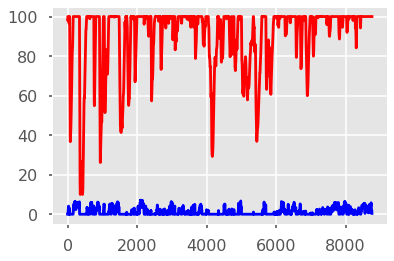

In [325]:

#plt.plot(charges_best)
#plt.plot(discharges_best)
plt.plot(np.array(stored_best)/storage_best*100)
plt.plot(np.array(losses_best[1:])/storage_best*100)

In [71]:
discharges_best

[14446496.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.

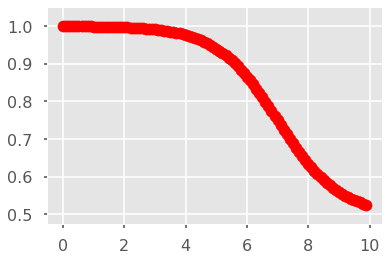

In [269]:
x = np.arange(0,10,0.1)
k=1
y = (1+1/(1+np.exp(k*(x-7))))*0.5
plt.scatter(x,y)

# We introduce a decay in load factor depending on installed capacity
wind_actual_capa = (1+1/(1+np.exp(k*(wind_capa*1/10.-7))))*0.5*wind_capa